In [1]:
%pylab inline
import os
import laspy
import fiona
import shapely
import shapely.geometry
import rasterio
from pprint import pprint
from tqdm import tnrange, tqdm_notebook
import rasterio.crs
from glob import glob
from time import sleep
import gc
import traceback

Populating the interactive namespace from numpy and matplotlib


## Open the Vector File

The vector file is manually labeled with all transformer boxes annotated clockwise(counter-clockwise?) facing the road. The projection srs(spatial reference system) is epsg:26949

In [2]:
VECTOR_DATA_FN = r'/home/femianjc/shared/srp/boxes11/boxes_section11.shp'
assert os.path.isfile(VECTOR_DATA_FN)

# These are the points we manually marked
vector_file = fiona.open(VECTOR_DATA_FN)

GROUND_FN = r'/home/femianjc/shared/srp/ground/merged_ground.asc'
assert os.path.isfile(GROUND_FN)

In [3]:
OUTPUT_METERS_PER_PIXEL = .05 # five centimeters, about 2 inches
OUTPUT_PADDING = 5 # expand output region 5 meters (to fit a local neighborhood into the image at the edges)

In [4]:
minx, miny, maxx, maxy = vector_file.bounds

# Expand the region so that a local window centered at points on the edges
# does not go outside the grid
minx -= OUTPUT_PADDING
miny -= OUTPUT_PADDING
maxx += OUTPUT_PADDING
maxy += OUTPUT_PADDING

print "Region of interest (based on vector data)"
print minx, miny, "--", maxx, maxy 

Region of interest (based on vector data)
231638.410976 251008.999357 -- 233216.25982 252568.834735


In [5]:
minx, miny, maxx, maxy = vector_file.bounds

# Expand the region so that a local window centered at points on the edges
# does not go outside the grid
minx -= OUTPUT_PADDING
miny -= OUTPUT_PADDING
maxx += OUTPUT_PADDING
maxy += OUTPUT_PADDING

print "Region of interest (based on vector data)"
print minx, miny, "--", maxx, maxy 

Region of interest (based on vector data)
231638.410976 251008.999357 -- 233216.25982 252568.834735


In [6]:
width_in_meters = maxx-minx
height_in_meters = maxy-miny
print 'width (m):', width_in_meters
print 'height (m):', height_in_meters

width (m): 1577.84884394
height (m): 1559.83537839


In [7]:
grid_width = int(round(width_in_meters/OUTPUT_METERS_PER_PIXEL))
grid_height = int(round(height_in_meters/OUTPUT_METERS_PER_PIXEL))
print 'grid width (cols):', grid_width
print 'grid height (rows):', grid_height

grid width (cols): 31557
grid height (rows): 31197


**Note**: We also convereted the srs and made it a geojson file afterwards

# Proccess the laz tiles

These are the lidar tiles that we already processed.

In [8]:
pattern = os.path.join(r'/media/femianjc/srpdisk/ASU_LiDAR_Processing/section11/tiled/50/*.laz')
jobs = glob(pattern)
print len(jobs)

1680


In [9]:
def save_stack(stack, las_fn, min_point, max_point, las_width, las_height):
    """Give a las file name, and a raster 'stack' computed bases on it, save 
    output to an appropriately named location. 
    
    When this is called, the LIDAR data has already been read and an ndarray called 'stack' has been
    created based on it. This function just determines the files name and location and saves it to disk. 
    
    :param[in] stack: The raster file. 
    :param[in] las_fn: Tha name of the LAS file that was used to generate the stack/raster file. 
    :param[in] min_point: The miimim LIDAR point in the stack. 
    :param[in] max_point: The maximum LIDAR point in the stack
    :param[in] las_width: The width of the stack?
    :param[in] las_height: The height of the stack?
    
    :return: The path to the file that we saves. 
    """
    output_transform = rasterio.transform.from_bounds(min_point[0], min_point[1],
                                                      max_point[0], max_point[1], 
                                                      las_width, las_height)
    output_crs = rasterio.crs.from_epsg(26949)

    output_fn = os.path.basename(las_fn)[:-3] + 'tif'
    
    # Replace output file if it already existed
    if os.path.isfile(output_fn):
        os.remove(output_fn)
        
    #Create a new raster file with the right shape & geo-location
    output_file = rasterio.open(output_fn, 'w', 
                            driver=u'GTiff', 
                            crs = output_crs,
                            transform=output_transform,
                            dtype=rasterio.uint16, 
                            count=3, 
                            width=las_width, 
                            height=las_height)
    
    # Write out the stack-raster-data and close the file
    output_file.write(indexes=(1,2,3), src=stack.astype(np.uint16))
    output_file.close()
    
    
    return output_fn

In [10]:
def process_las_file(las_fn):
    """Processes a single LAS/LAZ file
    This function either returns the name of a file, or an exception object. 
    It is intended to be used in multiproccessing.Pool.imap
    """
    output_fn = ''
    gc.collect()
    try:
        las_file = laspy.file.File(las_fn)
        X = las_file.x
        Y = las_file.y
        Z = las_file.z
        min_point = las_file.header.min
        max_point = las_file.header.max
        las_file.close()
        
        if max_point[0] < minx or min_point[0] > maxx or max_point[1] < miny or min_point[1] > maxy:
            return "Skipping {}, out-of-bounds file".format(os.path.split(las_fn)[1])

        las_min_x = int(floor((min_point[0] - minx) / OUTPUT_METERS_PER_PIXEL))
        las_min_y = int(floor((min_point[1] - miny) / OUTPUT_METERS_PER_PIXEL))
        las_max_x = int(floor((max_point[0] - minx) / OUTPUT_METERS_PER_PIXEL))
        las_max_y = int(floor((max_point[1] - miny) / OUTPUT_METERS_PER_PIXEL))
        las_width = las_max_x - las_min_x + 1
        las_height = las_max_y - las_min_y + 1

        ground_file = rasterio.open(GROUND_FN)
        ground_min_x, ground_min_y = ~(ground_file.affine)*(min_point[0], min_point[1])
        ground_max_x, ground_max_y = ~(ground_file.affine)*(max_point[0], max_point[1])
        ground_min_x = int(round(ground_min_x))
        ground_min_y = int(round(ground_min_y))
        ground_max_x = int(round(ground_max_x))
        ground_max_y = int(round(ground_max_y))

        flipped = False
        if ground_max_y <  ground_min_y:
            ground_min_y, ground_max_y = ground_max_y, ground_min_y
            flipped = True

        ground_width = ground_max_x - ground_min_x + 1
        ground_height = ground_max_y - ground_min_y + 1

        ground = ground_file.read(1, 
                                  window=((ground_min_y, ground_max_y + 1), (ground_min_x, ground_max_x + 1)), 
                                  boundless=True)
        if flipped:
            ground = ground[::-1,:] 
        ground_file.close()

        # Find the rows and columsn of each LIDAR point in the _output_ file. 
        C = np.floor(((X - minx)/OUTPUT_METERS_PER_PIXEL)).astype(int) - las_min_x
        R = np.floor(((Y - miny)/OUTPUT_METERS_PER_PIXEL)).astype(int) - las_min_y

        # Subtract the corresponding value from the _ground_ file to get height-above-ground. 
        height_above_ground = Z - ground[(R*ground_height)/las_height, (C*ground_width)/las_width]      

        # Determine how many slices above the ground each point is at. 
        level = np.floor((height_above_ground)/SLICE_THICKNESS).astype(int)
        
        def _generate_level(lvl):
            bc = np.bincount(R[level==lvl]*las_width + C[level==lvl], minlength=las_width*las_height)
            output = bc.reshape((las_height, las_width)).astype(float)
            return output

        # Count the number of LIDAR points in each slice (for slices 1, 2, 3). 
        # Note this does not include 0
        stack = np.stack([_generate_level(lvl) for lvl in 1,2,3])

        # I seem to be working upside-down...
        output_fn = save_stack(stack[:,::-1,:], las_fn,  min_point, max_point, las_width, las_height)
    except e:
        return (e, traceback.format_exc())
    
    return output_fn 

**NOTE**:  Somehow fiona was unable to open the shapefile, so I converted it to a GeoJSON file with:
```bash
    ogr2ogr boxe_section11.json boxes_section11.shp -f GeoJSON 
```

## Check the Result

Here we are able to show that the vector file line-up perfectly with high-resolution raster file.

In [88]:
output_ds = rasterio.open('/home/femianjc/shared/srp/try2/stack.vrt')
vector_file = fiona.open('/home/femianjc/shared/srp/boxes11/boxes_section11-epsg26949.json.geojson')

print vector_file.meta
print 'Number of features: ', len(vector_file)

{'crs': {'init': u'epsg:26949'}, 'driver': u'GeoJSON', 'schema': {'geometry': 'LineString', 'properties': OrderedDict([(u'id', 'str')])}}
Number of features:  226


In [89]:
# finding the center of all features, store as a list of arrays
hotspots = [array(f['geometry']['coordinates']).mean(0) for f in vector_file if f['geometry'] is not None]

In [121]:
rgb.close()

{'count': 3, 'crs': {'init': u'epsg:26949'}, 'dtype': 'uint8', 'affine': Affine(0.0762000000000344, 0.0, 231616.07220000058,
       0.0, -0.0762000000000344, 252585.62640000123), 'driver': u'GTiff', 'transform': (231616.07220000058, 0.0762000000000344, 0.0, 252585.62640000123, 0.0, -0.0762000000000344), 'height': 21555, 'width': 21275, 'nodata': None}


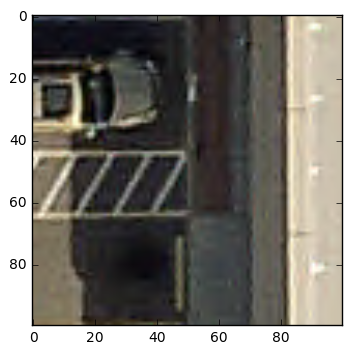

In [143]:
rgb = rasterio.open('/home/femianjc/Projects/SRP/transformer_box/sec11-26949.tif')

print rgb.meta

test = rgb.read(window=((1000,1100),(1000,1100)))

imshow(test.transpose(1,2,0))

[ 232623.16766725  251355.94989586]
[20484 24882]


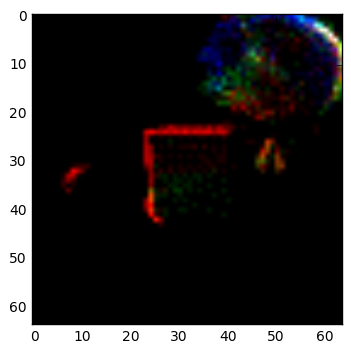

In [152]:
# checking a random feature
hs = hotspots[randint(len(hotspots))]
ctr = hs
print ctr

cr = np.asarray(~output_ds.affine * ctr).astype(int)
c, r = cr
print cr

window = ((r-32, r+32), (c-32, c+32))
data = output_ds.read(window=window, boundless=True)

figsize(4,4)
# data.shape = (3,64,64)
imshow((data.transpose(1,2,0)/20.).clip(0, 1))

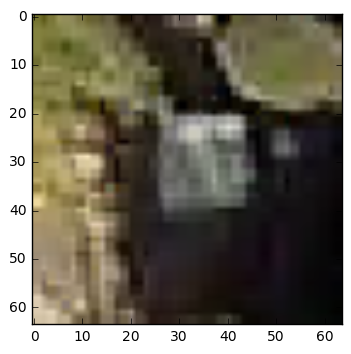

In [153]:
rgb_data = rgb.read(window=rgb.window(*output_ds.window_bounds(window), boundless=True), 
                    boundless=True, 
                    out=np.empty((3, 64, 64), dtype=np.uint8))
imshow(rgb_data.transpose(1,2,0))

In [99]:
rgb_data

array([[[  3.83932618e-34,   0.00000000e+00,   1.51095105e-34, ...,
           9.10844002e-44,   1.45735040e-43,   1.49938936e-43],
        [  1.47136339e-43,   9.10844002e-44,   9.10844002e-44, ...,
           1.52741533e-43,   1.70958413e-43,   1.40129846e-43],
        [  6.86636248e-44,   1.40129846e-43,   1.12103877e-43, ...,
           1.09301280e-43,   1.44333742e-43,   1.21912966e-43],
        ..., 
        [  6.02558340e-44,   1.47136339e-43,   1.55544130e-43, ...,
           7.28675201e-44,   1.42932443e-43,   1.23314265e-43],
        [  7.00649232e-44,   1.12103877e-43,   1.06498683e-43, ...,
           1.62550622e-43,   1.20511668e-43,   1.63951920e-43],
        [  1.48537637e-43,   1.52741533e-43,   1.05097385e-43, ...,
           1.59748025e-43,   1.52741533e-43,   1.14906474e-43]],

       [[  1.23314265e-43,   9.10844002e-44,   1.12103877e-43, ...,
           1.40129846e-43,   1.44333742e-43,   6.02558340e-44],
        [  7.84727140e-44,   1.58346726e-43,   7.14662217e-4

## Generate the database

We use our *data_provider.py* to rotate features already been marked.

In [ ]:
%%file data_provider.py

import pyproj
import rasterio
import numpy as np
import scipy.ndimage
from scipy.ndimage import zoom
from math import cos, sin, radians, atan2, degrees
from collections import namedtuple

Predictions = namedtuple('Predictions', ['x', 'y', 'label', 'dx', 'dy', 'angle'])
Sample = namedtuple('Sample', ['data', 'predicted'])

EPSG2223 = pyproj.Proj(init="epsg:2223", preserve_units=True)
EPSG26949 = pyproj.Proj(init="epsg:26949", preserve_units=True)
        
def normalize_angle(angle):
    angle = radians(angle)
    angle = atan2(sin(angle), cos(angle))
    angle = degrees(angle)
    return angle
    
class DataProvider(object):
    def __init__(self, radius_in_pixels=32, jitter=0.25):        
        self.densities_path = '/home/femianjc/shared/srp/try2/stack.vrt'
        
        #self.colors_path = '/home/femianjc/shared/srp/sample_locations_epsg26949.npzb (this is the old raster)
        # High resolution image. We used:
        # !gdalwarp -t_srs epsg:26949 -srcnodata None sec11.tif sec11-26949 -ot Byte
        # to convert it into new coordinate plus fixed nodata issue
        
        self.colors_path = '/home/femianjc/Projects/SRP/transformer_box/sec11-26949.tif'
        self.sample_path = '/home/femianjc/shared/srp/sample_locations_epsg26949.npz'
        self.radius_in_pixels = radius_in_pixels
        self.jitter = jitter
        self._open_datasets()
      
    def _open_datasets(self):
        self.densities = rasterio.open(self.densities_path)
        self.colors = rasterio.open(self.colors_path)
        samples= np.load(self.sample_path)
        # samples.files
        self.pos_xy = samples['pos_xy']
        self.neg_xy = samples['neg_xy']
        self.pos_angles = samples['pos_angles']
    
    def random_positive(self, jitter=None, rotate=True):
        jitter = self.jitter if jitter is None else jitter
        index = np.random.randint(len(self.pos_xy))
        dx, dy = jitter*np.random.randn(2)
        x, y = self.pos_xy[index] 
        x -= dx
        y -= dy
        label=1
        if rotate:
            rotation = np.random.randint(0, 360)
            patch = self.get_patch_xyr(x, y, rotation)        
            angle = normalize_angle(rotation + self.pos_angles[index])
        else:
            patch = self.get_patch_xy(x, y)
            angle = self.pos_angles[index]
            
        return Sample(patch, Predictions(x, y, label, dx, dy, angle))
    
    def random_negative(self, jitter=None, rotate=True):
        jitter = self.jitter if jitter is None else jitter
        index = np.random.randint(len(self.neg_xy))
        dx, dy = jitter*np.random.randn(2)
        x, y = self.neg_xy[index] 
        x -= dx
        y -= dy
        label = 0
        
        if rotate:
            rotation = np.random.randint(0, 360)
            patch = self.get_patch_xyr(x, y, rotation)        
            angle = normalize_angle(rotation)
        else:
            patch = self.get_patch_xy(x, y)
            angle = 0
            
        return Sample(patch, Predictions(x, y, label, dx, dy, angle))
    
    def random_sample(self, jitter=None, rotate=True, prob_positive=0.5):
        jitter = self.jitter if jitter is None else jitter
        if np.random.rand() > prob_positive:
            return self.random_negative(jitter, rotate)
        else:
            return self.random_positive(jitter, rotate)
        
    def get_patch_xyr(self, x, y, angle, radius_in_pixels=None):
        radius_in_pixels = radius_in_pixels or self.radius_in_pixels
        
        source_patch = self.get_patch_xy(x, y, radius_in_pixels*2)
        width = height = 2*radius_in_pixels
                
        radians = np.radians(angle)
        c, s = cos(radians), sin(radians)
        R = np.matrix([[c, -s], 
                       [s, c]])
        X = np.asarray([width, height])
        X = np.asarray(X-R.dot(X)).flatten()
        
        rotated_patch = np.empty_like(source_patch)
        for i in range(len(rotated_patch)):
            scipy.ndimage.affine_transform(source_patch[i],
                                           matrix=R, offset=X, 
                                           output_shape = rotated_patch[i].shape,
                                           output=rotated_patch[i])
        
        x, y = int((source_patch.shape[2]-width)/2), int( (source_patch.shape[1]-height)/2)
        cropped_patch = rotated_patch[:, y:y+height, x:x+width].copy()
        return cropped_patch    
        
    
    def get_patch_xy(self, x, y, radius_in_pixels=None):
        R = radius_in_pixels or self.radius_in_pixels
        # R = radius_in_pixels
        # x_2223, y_2223 = pyproj.transform(EPSG26949, EPSG2223, x, y)
        # c_2223, r_2223 = np.asarray(~self.colors.affine * (x_2223, y_2223)).astype(int)
        c, r = np.asarray(~self.densities.affine*(x, y)).astype(int)
        window = ((r-R, r+R), (c-R, c+R))
        data = self.densities.read(window=window, boundless=True)

        colors = self.colors.read(window=self.colors.window(*self.densities.window_bounds(window), boundless=True), 
                            boundless=True, 
                            out=np.empty((3, 2*R, 2*R), dtype=np.uint8))
        # colors = self.colors.read(window=((r_2223-R, r_2223+R), (c_2223-R, c_2223+R)), 
                                  # boundless=True).astype(np.float32)/255.
        colors = colors.astype(np.float32)/255.
        densities = self.densities.read(window=((r-R, r+R), (c-R, c+R)),
                                        boundless=True).astype(np.float32)
        
        combined = np.concatenate([colors, densities])
        
        return combined
    

In [155]:
import data_provider
reload(data_provider)
from pandas import DataFrame

DataProvider = data_provider.DataProvider
gtp = DataProvider(radius_in_pixels=32, jitter=0.25)

(6, 64, 64)


,x,y,label,dx,dy,angle
0,231714.034896,252364.087959,1,-0.006949,-0.188229,175.654991


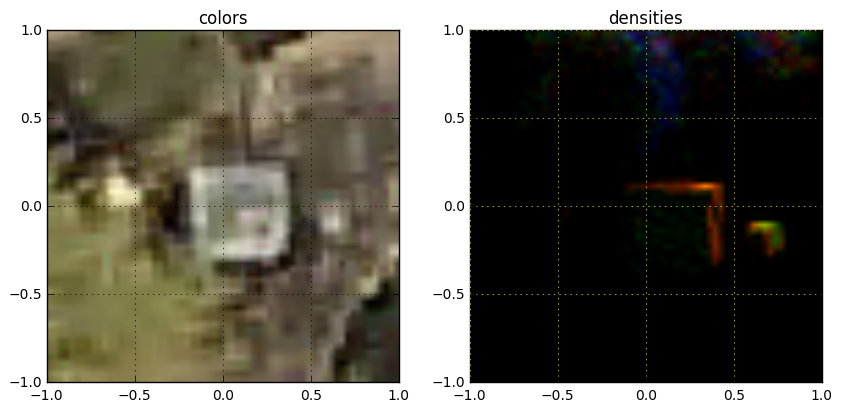

In [160]:
patch, labels = gtp.random_positive()
print patch.shape
figsize(10,10)
subplot(1,2,1)
imshow(patch[:3,:,:].transpose(1,2,0).clip(0,1), extent=(-1,1,-1,1))
xlim(-1,1)
ylim(-1,1)
grid()
title('colors')

im = (patch[3:6,:,:]/40).transpose(1,2,0).clip(0,1)
subplot(1,2,2)
imshow(im, extent=(-1,1,-1,1))
#xlim(-1,1)
#ylim(-1,1)
title('densities');
grid(color='yellow')
display(DataFrame([labels], columns=data_provider.Predictions._fields))